In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from scipy.stats import pearsonr, spearmanr, fisher_exact, mannwhitneyu, ttest_ind

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

from matplotlib.pyplot import rc_context
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
sys.path.append('../../../Code/')
from utils import read_dataset_log
import pickle as pkl
import matplotlib.gridspec as gridspec
from starcat import starCAT

In [2]:
from utils import compute_smooth_scatter_color

In [ ]:
from matplotlib import rcParams, font_manager

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
#rcParams['text.usetex'] = True

In [3]:
figdir = '../../../Figures/Components'

In [4]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [5]:
gep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))
shorten_map = dict(zip(gep_info['Short_Name'], gep_info['Shortest_Name']))

In [6]:
lineage_geps = gep_info[gep_info['Class']=='Lineage']['Short_Name'].tolist()

In [7]:
cc_geps = ['CellCycle-G2M', 'CellCycle-S', 'CellCycle-Late-S']

In [8]:
activation_threshold = 0.0625

In [9]:
params.columns

Index(['dataset', 'usage_fn', 'gene_scores_fn', 'gene_tpm_fn', 'tcat_fn',
       'tcat_fn_withsingletons', 'manual_gating_fn',
       'manual_activation_gating_fn', 'activation_score_fn', 'metadata_fn',
       'Processing notebook path', 'cNMF notebook path', 'cluster_col',
       'sample_col', 'individual_col', 'name', 'cnmf_dir', 'k', 'dt',
       'processed_forcnmf_fn', 'tpm_counts_for_cnmf_fn', 'raw_counts_filt_fn',
       'raw_counts_fn', 'dataset_type', 'tissue_type', 'context_label',
       'tcat_fn_old'],
      dtype='object')

In [10]:
dataset = 'AMP-RA'

In [11]:
meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], sep='\t', index_col=0)
individual_col = params.loc[dataset, 'individual_col']
sample_col = params.loc[dataset, 'sample_col']
count_fn = params.loc[dataset, 'raw_counts_filt_fn']
adata = sc.read(count_fn)
    

usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
usage.columns = usage.columns.map(rename_map)
usage_norm = usage.div(usage.sum(axis=1), axis=0)
    
activation = pd.read_csv(params.loc[dataset, 'activation_score_fn'], index_col = 0, sep = '\t')
meta['Activation_Score'] = activation.loc[meta.index, 'Activation_Score']
meta['CellCycle_Usage'] = usage_norm.loc[meta.index, cc_geps].sum(axis=1)
meta['Exhaustion_Usage'] = usage_norm.loc[meta.index, 'Exhaustion']
meta['CellCycle_Bin'] = meta['CellCycle_Usage']>activation_threshold
meta['Exhaustion_Bin'] = meta['Exhaustion_Usage']>activation_threshold

meta.rename(columns={individual_col:'individual', sample_col:'sample'}, inplace=True)

Only considering the two last: ['.FiltForcNMF', '.h5ad'].
Only considering the two last: ['.FiltForcNMF', '.h5ad'].


In [12]:
tcat = starCAT(reference='TCAT.V1', cachedir='./cache')

Using reference from starCAT database
Loading reference from existing cache file for reference TCAT.V1


In [13]:
usage, scores = tcat.fit_transform(adata)

3412 out of 3412 genes in the reference overlap with the query


/PHShome/dk718/miniforge3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].values

In [15]:
for c in scores.columns:
    adata.obs[c] = scores[c]
scores.head()

,ASA,Proliferation,ASA_binary,Proliferation_binary,Multinomial_Label
BRI-399_AAACGAATCTGCATGA,0.021718,0.004395,False,False,CD4_CM
BRI-399_AAACGCTTCCTTGACC,0.012247,0.008618,False,False,CD8_Naive
BRI-399_AAAGGGCAGCCGGAAT,0.020567,0.002566,False,False,Treg
BRI-399_AAAGGGCCACTATGTG,0.032999,0.004372,False,False,CD8_TEMRA
BRI-399_AAAGGTAGTGCAGGAT,0.041137,0.002224,False,False,Treg


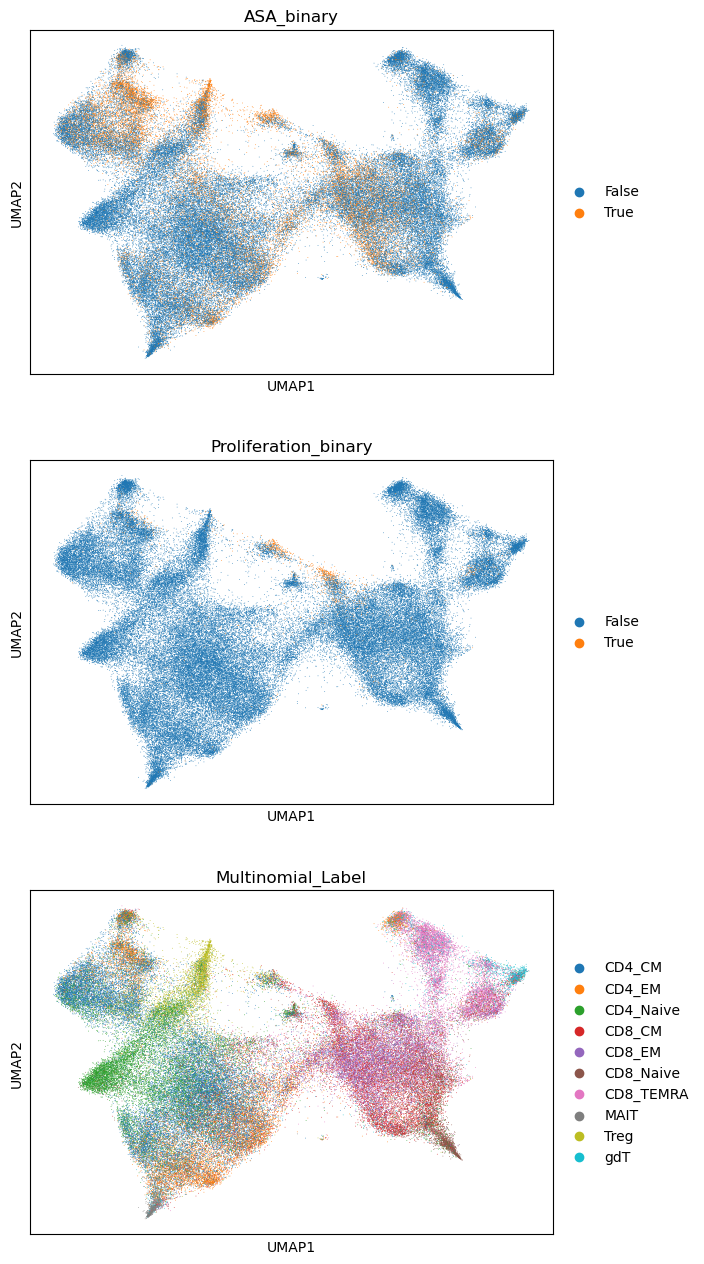

In [16]:
sc.pl.umap(adata, color=['ASA_binary', 'Proliferation_binary', 'Multinomial_Label'], ncols=1)

In [24]:
meta['Activation_Score_Smoothed'] = compute_smooth_scatter_color(meta['UMAP1'].values.reshape(-1),
                                                                 meta['UMAP2'].values.reshape(-1),
                                                                 meta['Activation_Score'].values.reshape(-1), n_neighbors=5)

In [33]:
meta['Proliferation_Smoothed'] = compute_smooth_scatter_color(meta['UMAP1'].values.reshape(-1),
                                                                 meta['UMAP2'].values.reshape(-1),
                                                                 meta['CellCycle_Usage'].values.reshape(-1), n_neighbors=5)

In [26]:
th17_usage = usage[['Th17-Resting','Th17-Activated']].sum(axis=1)
meta['th17'] = th17_usage.loc[meta.index]
meta['th17_Smoothed'] = compute_smooth_scatter_color(meta['UMAP1'].values.reshape(-1),
                                                                 meta['UMAP2'].values.reshape(-1),
                                                                 meta['th17'].values.reshape(-1), n_neighbors=5)

In [43]:
th2_usage = usage[['Th2-Resting','Th2-Activated']].sum(axis=1)
meta['th2'] = th2_usage.loc[meta.index]
meta['th2_Smoothed'] = compute_smooth_scatter_color(meta['UMAP1'].values.reshape(-1),
                                                                 meta['UMAP2'].values.reshape(-1),
                                                                 meta['th2'].values.reshape(-1), n_neighbors=5)

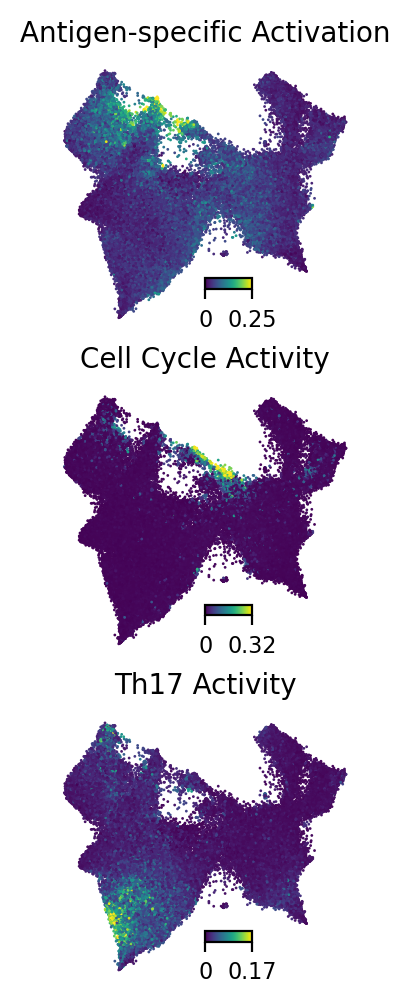

In [41]:
cbarinfo = [.5, .15, .15, .04]

(fig,axes) = plt.subplots(3,1, figsize=(2,6), dpi=200)

ax = axes[0]

vmax = meta['Activation_Score_Smoothed'].quantile(0.999)
scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['Activation_Score_Smoothed'], s=1, edgecolor='None', vmax=vmax)
ax.set_title('Antigen-specific Activation', fontsize=10)
#ax.set_xlabel('UMAP 1', fontsize=10)
#ax.set_ylabel('UMAP 2', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.inset_axes(cbarinfo, transform=ax.transAxes)
fig.colorbar(scim, ax=ax, cax=cax, orientation='horizontal', ticks=[0.001, vmax])
cax.set_xticklabels(['0', '%.2f' % vmax], fontsize=8)

ax = axes[1]

vmax = meta['Proliferation_Smoothed'].quantile(0.999)
scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['Proliferation_Smoothed'], s=1, edgecolor='None', vmax=vmax)
ax.set_title('Cell Cycle Activity', fontsize=10)
#ax.set_xlabel('UMAP 1', fontsize=10)
#ax.set_ylabel('UMAP 2', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.inset_axes(cbarinfo, transform=ax.transAxes)
fig.colorbar(scim, ax=ax, cax=cax, orientation='horizontal', ticks=[0.001, vmax])
cax.set_xticklabels(['0', '%.2f' % vmax], fontsize=8)


ax = axes[2]

vmax = meta['th17_Smoothed'].quantile(0.999)
scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['th17_Smoothed'], s=1, edgecolor='None', vmax=vmax)
ax.set_title('Th17 Activity', fontsize=10)
#ax.set_xlabel('UMAP 1', fontsize=10)
#ax.set_ylabel('UMAP 2', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.inset_axes(cbarinfo, transform=ax.transAxes)
fig.colorbar(scim, ax=ax, cax=cax, orientation='horizontal', ticks=[0.001, vmax])
cax.set_xticklabels(['0', '%.2f' % vmax], fontsize=8)



plt.savefig('../../../Figures/AMPRA_ASA.png')

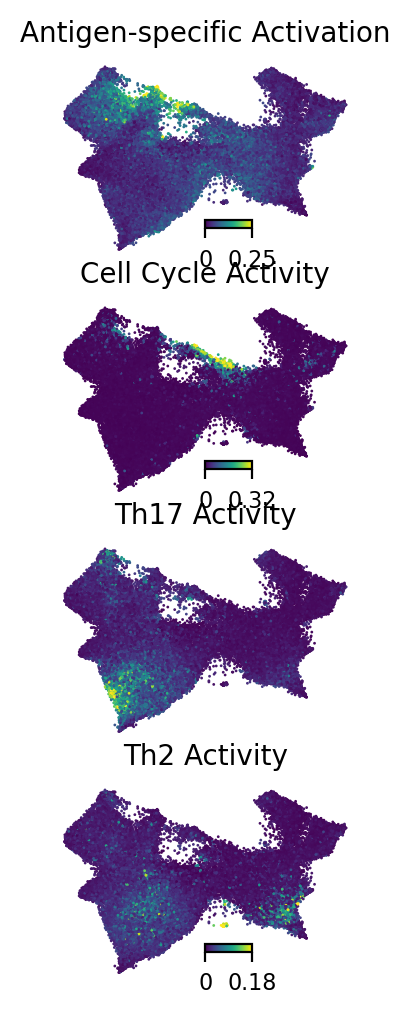

In [44]:
cbarinfo = [.5, .15, .15, .04]

(fig,axes) = plt.subplots(4,1, figsize=(2,6), dpi=200)

ax = axes[0]

vmax = meta['Activation_Score_Smoothed'].quantile(0.999)
scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['Activation_Score_Smoothed'], s=1, edgecolor='None', vmax=vmax)
ax.set_title('Antigen-specific Activation', fontsize=10)
#ax.set_xlabel('UMAP 1', fontsize=10)
#ax.set_ylabel('UMAP 2', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.inset_axes(cbarinfo, transform=ax.transAxes)
fig.colorbar(scim, ax=ax, cax=cax, orientation='horizontal', ticks=[0.001, vmax])
cax.set_xticklabels(['0', '%.2f' % vmax], fontsize=8)

ax = axes[1]

vmax = meta['Proliferation_Smoothed'].quantile(0.999)
scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['Proliferation_Smoothed'], s=1, edgecolor='None', vmax=vmax)
ax.set_title('Cell Cycle Activity', fontsize=10)
#ax.set_xlabel('UMAP 1', fontsize=10)
#ax.set_ylabel('UMAP 2', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.inset_axes(cbarinfo, transform=ax.transAxes)
fig.colorbar(scim, ax=ax, cax=cax, orientation='horizontal', ticks=[0.001, vmax])
cax.set_xticklabels(['0', '%.2f' % vmax], fontsize=8)


ax = axes[2]

vmax = meta['th17_Smoothed'].quantile(0.999)
scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['th17_Smoothed'], s=1, edgecolor='None', vmax=vmax)
ax.set_title('Th17 Activity', fontsize=10)
#ax.set_xlabel('UMAP 1', fontsize=10)
#ax.set_ylabel('UMAP 2', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])


ax = axes[3]

vmax = meta['th2_Smoothed'].quantile(0.999)
scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['th2_Smoothed'], s=1, edgecolor='None', vmax=vmax)
ax.set_title('Th2 Activity', fontsize=10)
#ax.set_xlabel('UMAP 1', fontsize=10)
#ax.set_ylabel('UMAP 2', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.inset_axes(cbarinfo, transform=ax.transAxes)
fig.colorbar(scim, ax=ax, cax=cax, orientation='horizontal', ticks=[0.001, vmax])
cax.set_xticklabels(['0', '%.2f' % vmax], fontsize=8)



plt.savefig('../../../Figures/AMPRA_ASA.png')

In [75]:
meta['Activation_Score_Smoothed'] = compute_smooth_scatter_color(meta['UMAP1'].values.reshape(-1),
                                                                 meta['UMAP2'].values.reshape(-1),
                                                                 meta['Activation_Score'].values.reshape(-1), n_neighbors=5)

In [141]:
sample_metafn = '/data/srlab1/mcurtis/GSK/tcell_proliferation/AMP_ADT/data/AMP_sample_metadata.txt'
sampmeta = pd.read_csv(sample_metafn, sep='\t')
sampmeta.tail()

,sample,new_class,pipeline_date,site,treatment,biopsied,disease_duration,das28_esr,das28_crp,das28_crp3,...,density_overall,aggr_overall,age,sex,ccp_result,rf_result,smoke_hx,smoke_current,grp_final_dfg,treatment_grp
77,BRI-629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,BRI-631,M,2019-10-28,Northwestern,methotrexate failure,Wrist,2.0,5.717572,5.247572,5.789330,...,1.4,0.0,24.0,1.0,4.8,59.0,0.0,NaN,2.0,nbDMARD
79,BRI-633R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,BRI-635,F,2019-10-28,Northwestern,methotrexate failure,Knee,3.1,2.573273,2.826263,3.125889,...,1.0,0.0,69.0,0.0,0.5,10.0,0.0,NaN,2.0,nbDMARD
81,BRI-637R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
sampmeta['Disease'] = np.nan
sampmeta.loc[sampmeta['treatment']=='OA', 'Disease'] = 'OA'
sampmeta.loc[(sampmeta['treatment']!='OA') & ~sampmeta['treatment'].isnull(), 'Disease'] = 'RA'

In [161]:
meta['Activation_Bin'] = meta['Activation_Score']>0.0625
meta['Exhaustion_Bin'] = meta['Exhaustion_Usage']>0.0625

<Axes: xlabel='Disease', ylabel='percent_activated'>

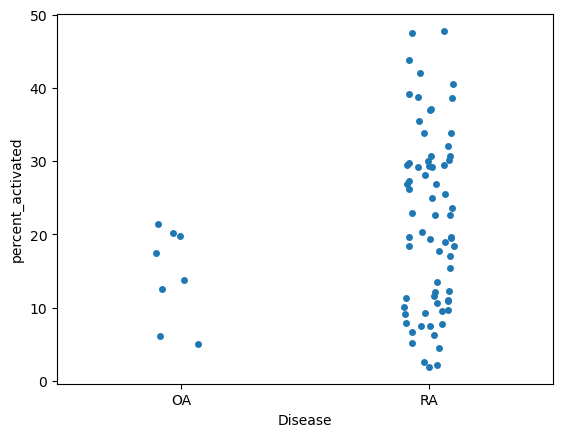

In [163]:
percent_activated = meta.groupby('sample')['Activation_Bin'].mean()*100
sampmeta.index = sampmeta['sample']
sampmeta['percent_activated'] = np.nan
sampmeta.loc[percent_activated.index, 'percent_activated'] = percent_activated.values
sns.stripplot(x='Disease', y='percent_activated', data=sampmeta)

<Axes: xlabel='Disease', ylabel='percent_exhausted'>

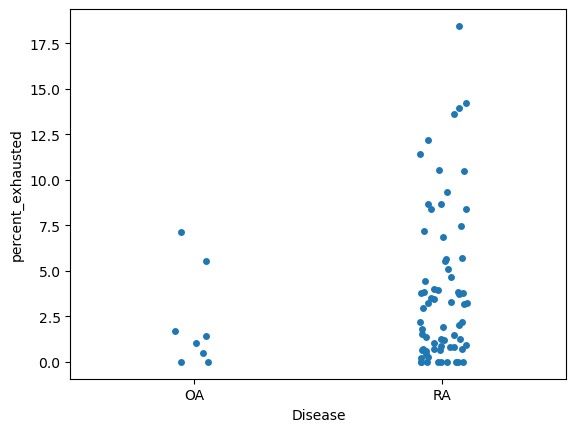

In [165]:
percent_exhausted = meta.groupby('sample')['Exhaustion_Bin'].mean()*100
sampmeta.index = sampmeta['sample']
sampmeta['percent_exhausted'] = np.nan
sampmeta.loc[percent_activated.index, 'percent_exhausted'] = percent_exhausted.values
sns.stripplot(x='Disease', y='percent_exhausted', data=sampmeta)

<Axes: xlabel='new_class', ylabel='percent_activated'>

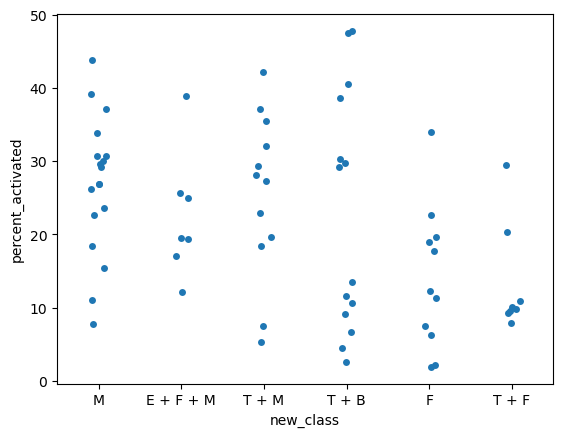

In [169]:
sns.stripplot(x='new_class', y='percent_activated', data=sampmeta)

<Axes: xlabel='new_class', ylabel='percent_exhausted'>

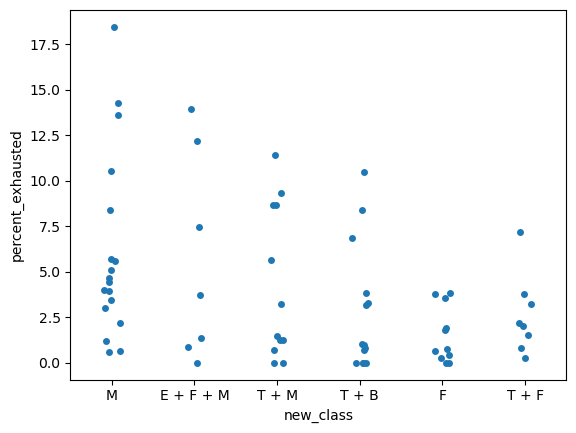

In [168]:

sns.stripplot(x='new_class', y='percent_exhausted', data=sampmeta)

<Axes: xlabel='treatment_grp', ylabel='percent_activated'>

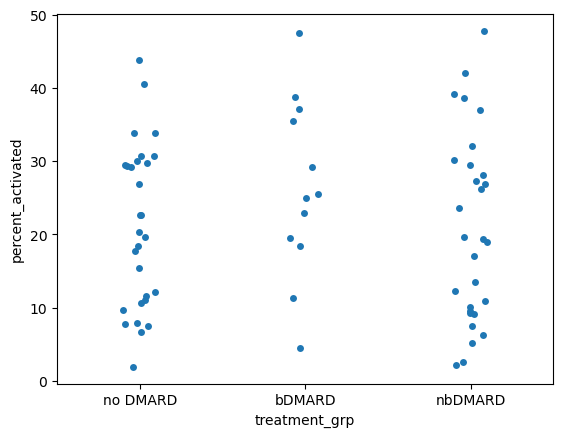

In [171]:
sns.stripplot(x='treatment_grp', y='percent_activated', data=sampmeta)

In [187]:
sampmeta.head(20).T

sample,BRI-399,BRI-401,BRI-403,BRI-405,BRI-407,BRI-409,BRI-411,BRI-413,BRI-415,BRI-417,BRI-419,BRI-421,BRI-425,BRI-427,BRI-429,BRI-431,BRI-436,BRI-438,BRI-440,BRI-442
sample,BRI-399,BRI-401,BRI-403,BRI-405,BRI-407,BRI-409,BRI-411,BRI-413,BRI-415,BRI-417,BRI-419,BRI-421,BRI-425,BRI-427,BRI-429,BRI-431,BRI-436,BRI-438,BRI-440,BRI-442
new_class,NaN,M,M,E + F + M,T + M,T + B,E + F + M,F,T + B,T + B,M,T + M,F,F,M,M,T + B,NaN,T + M,NaN
pipeline_date,2019-08-06,2019-08-06,2019-08-06,2019-08-06,2019-08-06,2019-08-06,2019-08-12,2019-08-12,2019-08-12,2019-08-12,2019-08-12,2019-08-12,2019-08-13,2019-08-13,2019-08-13,2019-08-13,2019-08-15,2019-08-15,2019-08-15,2019-08-15
site,University of Pittsburgh,Cedars,University of Rochester,Cedars,Columbia University,Northwestern,Cedars,University of Rochester,UK London,University of Colorado,Columbia University,UK Birmingham,UC San Diego,UC San Diego,Columbia University,Northwestern,University of Colorado,University of Pittsburgh,UK London,Hospital for Special Surgery
treatment,OA,treatment naive,methotrexate failure,TNF failure,methotrexate failure,methotrexate failure,TNF failure,treatment naive,treatment naive,methotrexate failure,treatment naive,treatment naive,methotrexate failure,TNF failure,methotrexate failure,methotrexate failure,treatment naive,OA,treatment naive,OA
biopsied,Knee,Knee,Wrist,Wrist,Wrist,Wrist,Wrist,Knee,Knee,Knee,Wrist,Knee,Knee,Knee,Wrist,Wrist,Wrist,Knee,Wrist,Ankle
disease_duration,NaN,2.1,1.5,16.0,6.9,3.8,15.3,0.0,0.0,16.4,1.6,0.0,0.7,0.1,10.2,2.5,4.0,NaN,0.0,NaN
das28_esr,NaN,3.191213,4.378193,3.056047,5.04115,3.04228,3.827836,7.098388,NaN,4.24089,4.743259,3.482577,NaN,5.880127,7.126368,3.181293,5.760173,NaN,NaN,NaN
das28_crp,NaN,2.848061,3.875981,3.642519,4.168509,2.154939,4.608431,6.059698,NaN,4.176972,3.918778,2.217939,NaN,4.83073,5.665181,1.916655,4.648808,NaN,NaN,NaN
das28_crp3,NaN,3.119067,4.303679,4.016071,4.55616,2.456733,5.078574,6.690368,4.703823,4.588569,4.281456,2.456733,NaN,5.315403,6.194799,2.17152,5.069088,NaN,5.500494,NaN


<Axes: xlabel='rf_result', ylabel='percent_activated'>

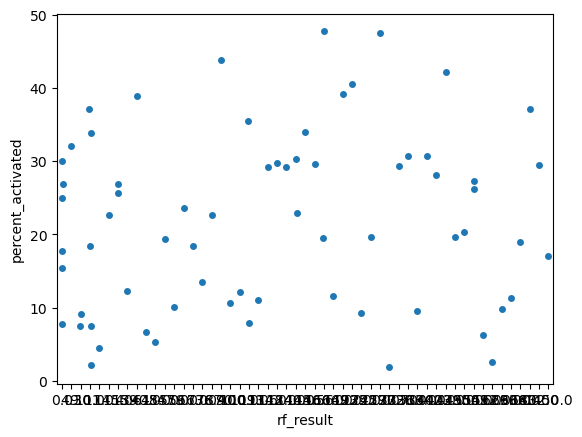

In [184]:
sns.stripplot(x='rf_result', y='percent_activated', data=sampmeta)

In [180]:
ind = ~sampmeta['krenn_inflam_overall'].isnull()
spearmanr(sampmeta.loc[ind, 'krenn_inflam_overall'], sampmeta.loc[ind, 'percent_activated'])

SignificanceResult(statistic=0.41640623102044516, pvalue=0.0004567504725078526)

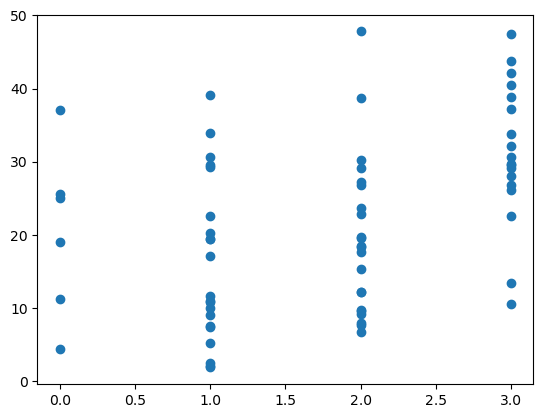

In [181]:
plt.scatter(sampmeta['krenn_inflam_overall'], sampmeta['percent_activated'])

In [182]:
ind = ~sampmeta['krenn_inflam_overall'].isnull()
spearmanr(sampmeta.loc[ind, 'krenn_inflam_overall'], sampmeta.loc[ind, 'percent_exhausted'])

SignificanceResult(statistic=0.31586611706280654, pvalue=0.009218300703984862)

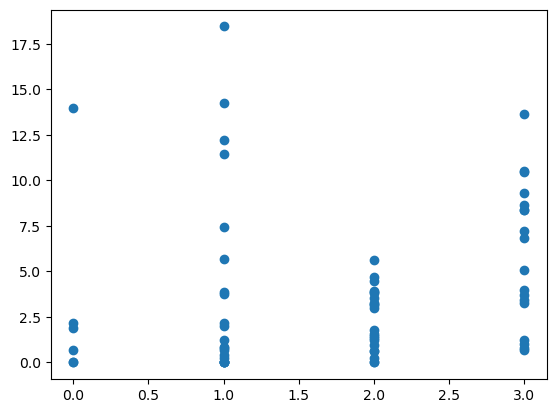

In [183]:
plt.scatter(sampmeta['krenn_inflam_overall'], sampmeta['percent_exhausted'])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

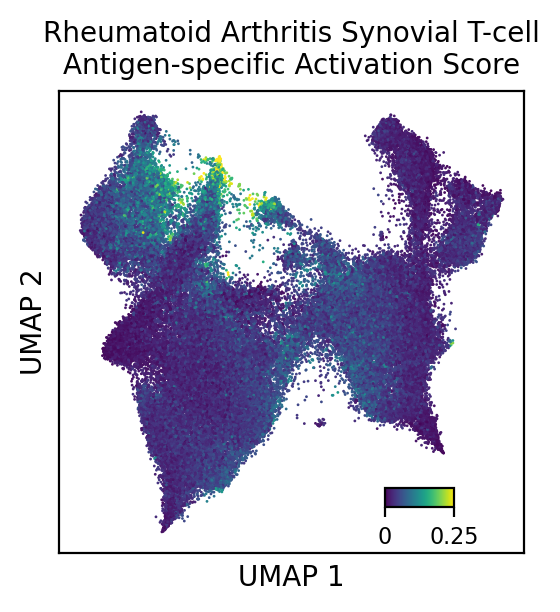

In [130]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
vmax = meta['Activation_Score_Smoothed'].quantile(0.999)
scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['Activation_Score_Smoothed'], s=1, edgecolor='None', vmax=vmax)
ax.set_title('Rheumatoid Arthritis Synovial T-cell\nAntigen-specific Activation Score', fontsize=10)
ax.set_xlabel('UMAP 1', fontsize=10)
ax.set_ylabel('UMAP 2', fontsize=10)

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.inset_axes([.7, .1, .15, .04], transform=ax.transAxes)
fig.colorbar(scim, ax=ax, cax=cax, orientation='horizontal', ticks=[0.001, vmax])
cax.set_xticklabels(['0', '%.2f' % vmax], fontsize=8)
#cax.set_title('Score', fontsize=8, pad=-1)

plt.savefig('../../../Figures/AMPRA_ASA.png')




findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


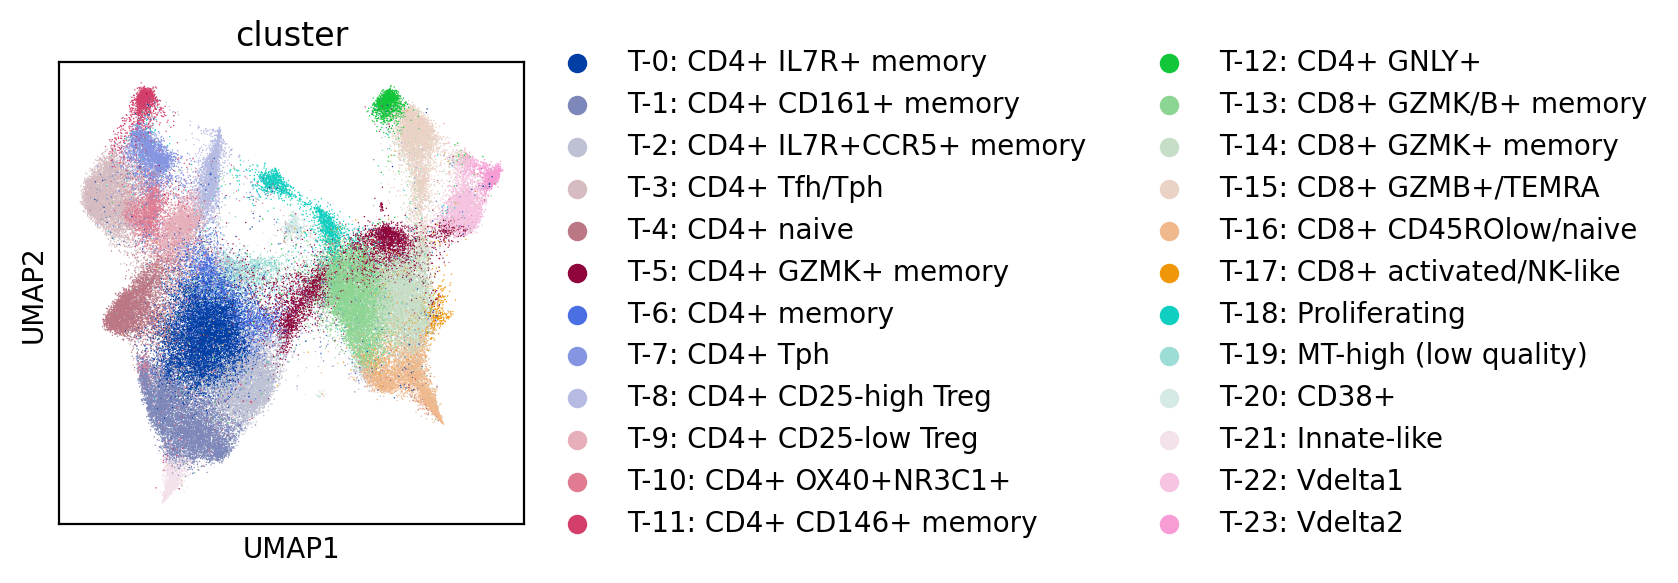

In [108]:
adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].values
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)
sc.pl.umap(adata, color='cluster', size=1, ax=ax, frameon=True)


In [128]:
meta['clusternum'] = meta['cluster'].apply(lambda x: int(x.split(':')[0].split('-')[1]))
cluster_order = meta.sort_values(by='clusternum')['cluster'].drop_duplicates()
meta['clustercolor'] = meta['clusternum'].apply(lambda x: adata.uns['cluster_colors'][x])

X = meta[['cluster', 'clustercolor']].drop_duplicates()
cmap = dict(zip(X['cluster'], X['clustercolor']))
cmap


{'T-6: CD4+ memory': '#4a6fe3',
 'T-5: CD4+ GZMK+ memory': '#8e063b',
 'T-8: CD4+ CD25-high Treg': '#b5bbe3',
 'T-22: Vdelta1': '#f6c4e1',
 'T-14: CD8+ GZMK+ memory': '#c6dec7',
 'T-2: CD4+ IL7R+CCR5+ memory': '#bec1d4',
 'T-12: CD4+ GNLY+': '#11c638',
 'T-4: CD4+ naive': '#bb7784',
 'T-0: CD4+ IL7R+ memory': '#023fa5',
 'T-3: CD4+ Tfh/Tph': '#d6bcc0',
 'T-1: CD4+ CD161+ memory': '#7d87b9',
 'T-16: CD8+ CD45ROlow/naive': '#f0b98d',
 'T-18: Proliferating': '#0fcfc0',
 'T-20: CD38+': '#d5eae7',
 'T-13: CD8+ GZMK/B+ memory': '#8dd593',
 'T-21: Innate-like': '#f3e1eb',
 'T-19: MT-high (low quality)': '#9cded6',
 'T-10: CD4+ OX40+NR3C1+': '#e07b91',
 'T-9: CD4+ CD25-low Treg': '#e6afb9',
 'T-15: CD8+ GZMB+/TEMRA': '#ead3c6',
 'T-11: CD4+ CD146+ memory': '#d33f6a',
 'T-7: CD4+ Tph': '#8595e1',
 'T-23: Vdelta2': '#f79cd4',
 'T-17: CD8+ activated/NK-like': '#ef9708'}

[]

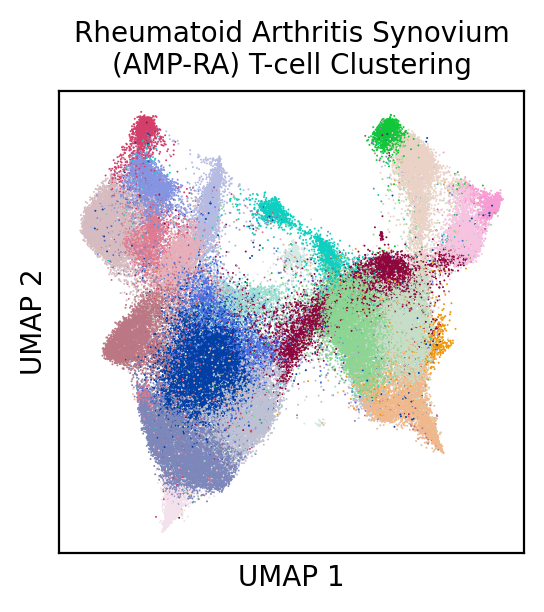

In [121]:
(fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=200)


scim = ax.scatter(meta['UMAP1'], meta['UMAP2'], c=meta['clustercolor'],
                      s=.5, edgecolor='None')

ax.set_title('Rheumatoid Arthritis Synovium\n(AMP-RA) T-cell Clustering', fontsize=10)
ax.set_xlabel('UMAP 1', fontsize=10)
ax.set_ylabel('UMAP 2', fontsize=10)




#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])



#plt.savefig('../../../Figures/AMPRA_ASA.png')



In [10]:
cd4_convs = ['CD4_Naive', 'CD4_CM', 'CD4_EM', 'CD4_TEMRA', 'CD4_Memory']

cd8_convs = [ 'CD8_TEMRA', 'CD8_EM', 'CD8_Naive', 'CD8_CM']

regs = ['Treg']
unconv = ['gdT', 'MAIT', 'DN']
mapping = dict(zip(cd4_convs + cd8_convs + regs + unconv, ['CD4 conv']*len(cd4_convs) + ['CD8 conv']*len(cd8_convs) + ['Treg']*len(regs) + ['unconv']*len(unconv)))
mapping

{'CD4_Naive': 'CD4 conv',
 'CD4_CM': 'CD4 conv',
 'CD4_EM': 'CD4 conv',
 'CD4_TEMRA': 'CD4 conv',
 'CD4_Memory': 'CD4 conv',
 'CD8_TEMRA': 'CD8 conv',
 'CD8_EM': 'CD8 conv',
 'CD8_Naive': 'CD8 conv',
 'CD8_CM': 'CD8 conv',
 'Treg': 'Treg',
 'gdT': 'unconv',
 'MAIT': 'unconv',
 'DN': 'unconv'}